In [1]:
%%time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
%matplotlib inline


Wall time: 4.35 s


In [2]:
df = pd.read_csv("train_v9rqX0R.csv")
display(df.head())
display(df.isnull().sum())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [3]:
print((df.isnull().sum()/df.shape[0])*100)
print(((df.isnull().sum()/df.shape[0])*100).mean())
df.shape
#about 4% oftotal data is missing
#in columns -- more than 10%


Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64
3.786812155344362


(8523, 12)

In [7]:
df1 = df.drop(['Item_Identifier', 'Outlet_Identifier' , 'Outlet_Establishment_Year'],axis = 1)
df1['Item_Fat_Content'].replace({'low fat': 'Low Fat' , 'LF' : 'Low Fat' , 'reg' :  'Regular' },inplace = True)

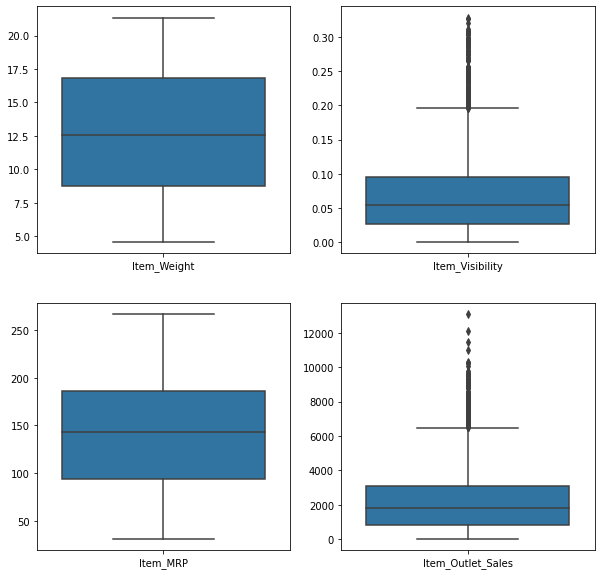

In [6]:
##KNN is sensitive to outliers and doesnt perform well when features that are heavily correlated
#replace ouliers with 95th percentile and then impute using KNN
fig, axes= plt.subplots(2, 2,figsize=(10,10)) 
sns.boxplot(data=df1[['Item_Weight']].dropna() ,orient= "v",ax=axes[0,0])
sns.boxplot(data=df1[['Item_Visibility']].dropna() ,orient= "v",ax=axes[0,1])
sns.boxplot(data=df1[['Item_MRP']] ,orient= "v",ax=axes[1,0])
sns.boxplot(data=df1[['Item_Outlet_Sales']] ,orient= "v",ax=axes[1,1])
#Item_Visibility has outliers
df1.loc[df1['Item_Visibility'] > 0.195979, 'Item_Visibility'] = df1['Item_Visibility'].quantile(0.95)


In [8]:
#item visibility cant be 0
df1['Item_Visibility'] = df1['Item_Visibility'].replace(0,np.nan)
df1.isnull().sum()

Item_Weight             1463
Item_Fat_Content           0
Item_Visibility          526
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

In [11]:
df1['Outlet_Size'].replace(['Medium', 'High', 'Small'],[2,1,3],inplace=True)
##to get dummies
df2 = df1.copy()
features = ['Item_Fat_Content' , 'Item_Type' ,'Outlet_Location_Type','Outlet_Type']
for f in features:
    d = pd.get_dummies(df1[f],drop_first=True)
    df2 = df2.drop(f,axis = 1)
    df2 = pd.concat([df2,d],axis=1)
df2.head(10)
##df2 -- without outliers; having missing values  
df2['Outlet_Size'].replace(['Medium', 'High', 'Small'],[2,1,3],inplace=True)

In [12]:
df22 = df2.copy()
df22['Outlet_Size'].fillna(df2.dropna()['Outlet_Size'].mode()[0], inplace=True)
df22['Item_Weight'].fillna(df2.dropna()['Item_Weight'].mean(), inplace=True)
df22['Item_Visibility'].fillna(df2.dropna()['Item_Visibility'].median(), inplace=True)
df22.shape
df22.head(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Regular,Breads,Breakfast,Canned,Dairy,...,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,Tier 2,Tier 3,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,9.30,0.016047,249.8092,2.0,3735.1380,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,5.92,0.019278,48.2692,2.0,443.4228,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


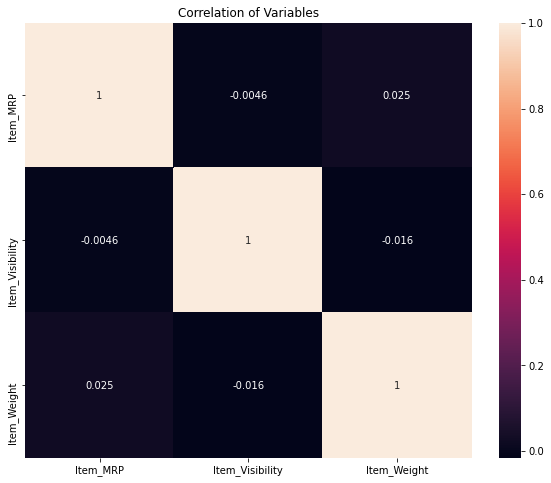

,feature,VIF
0,Item_MRP,4.417630
1,Item_Visibility,2.638746
2,Item_Weight,4.872095


In [13]:
#correlation between predictors
plt.figure(figsize = (10,8))
sns.heatmap((pd.DataFrame(df22, columns = ['Item_MRP', 'Item_Visibility','Item_Weight'])).corr(), annot=True)
plt.title('Correlation of Variables')
plt.show()
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
c = df22[['Item_MRP', 'Item_Visibility','Item_Weight']] 
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = c.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(c.values, i) 
                          for i in range(len(c.columns))] 
vif_data
#VIF < 5 (NOT SEVERE)

In [14]:
##Now apply KNN classification
###knn classifier for outlet size
X = df22.drop(['Outlet_Size' , 'Item_Outlet_Sales'], axis = 1)
y = df22['Outlet_Size']
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#Train Model and Predict
k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)
print("Accuracy of model at K=4 is",metrics.accuracy_score(y_test, Pred_y))


Accuracy of model at K=4 is 0.86158357771261


Minimum error:- 0.11906158357771261 at K = 30


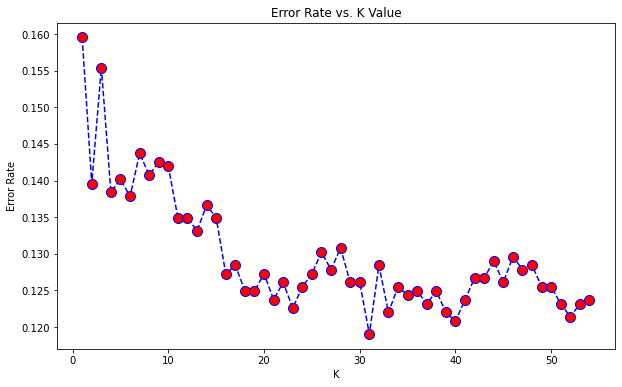

In [15]:
error_rate = []
for i in range(1,55):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,55),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:- 0.8809384164222874 at K = 30


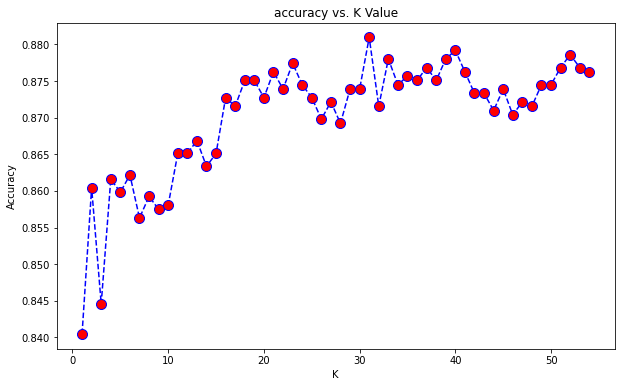

In [16]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,55):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,55),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [17]:
neigh = KNeighborsClassifier(n_neighbors =30).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)
print("Accuracy of model at K=30 is",metrics.accuracy_score(y_test, Pred_y))

Accuracy of model at K=30 is 0.873900293255132


In [20]:
dt = df2.loc[pd.isna(df2["Outlet_Size"]), :].index
dtest = df2.loc[dt,]
dtest['Item_Visibility'].fillna(df2.dropna()['Item_Visibility'].median(), inplace=True)
dtest.drop(['Outlet_Size' , 'Item_Outlet_Sales'],axis = 1,inplace=True)

In [21]:
pred = neigh.predict(dtest)
df22.iloc[dt,3] = pred



In [22]:
df22['Outlet_Size'].replace([2., 3., 1.],['Medium', 'High', 'Small'],inplace=True)
df2a = pd.get_dummies(df22['Outlet_Size'],drop_first=True)
df22 = df22.drop('Outlet_Size',axis = 1)
df22 = pd.concat([df2a,df22],axis=1)
df22.head(2)


,Medium,Small,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Regular,Breads,Breakfast,Canned,...,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,Tier 2,Tier 3,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,1,0,9.30,0.016047,249.8092,3735.1380,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,5.92,0.019278,48.2692,443.4228,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0


In [23]:
#LINEAR REGRESSION
import statsmodels.api as sm

df23 = df22.copy()
df23['log_y' ] = np.log(df22['Item_Outlet_Sales'])
##to use
X = df22[df22.drop( 'Item_Outlet_Sales',axis=1).columns]
y = df23['log_y']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     843.7
Date:                Wed, 07 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:27:36   Log-Likelihood:                -6800.3
No. Observations:                8523   AIC:                         1.365e+04
Df Residuals:                    8496   BIC:                         1.385e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.4107      0.041    108.736      0.000       4.331       4.490
Medium                    0.0447      0.025      1.789      0.074      -0.004       0.094
Small                     0.0109      0.041      0.265      0.791      -0.070       0.092
Item_Weight              -0.0004      0.001     -0.259      0.796      -0.003       0.002
Item_Visibility          -0.0294      0.126     -0.234      0.815      -0.276       0.217
Item_MRP                  0.0083   9.42e-05     88.261      0.000       0.008       0.009
Regular                   0.0137      0.013      1.014      0.310      -0.013       0.040
Breads                    0.0269      0.040      0.671      0.503      -0.052       0.105
Breakfast                -0.0692      0.056     -1.244      0.213      -0.178       0.040
Canned                    0.0255      0.030      0.853      0.394      -0.033       0.084
Dairy                    -0.0688      0.030     -2.321      0.020      -0.127      -0.011
Frozen Foods             -0.0532      0.028     -1.896      0.058      -0.108       0.002
Fruits and Vegetables    -0.0053      0.026     -0.203      0.839      -0.057       0.046
Hard Drinks              -0.0235      0.043     -0.547      0.585      -0.108       0.061
Health and Hygiene        0.0111      0.032      0.343      0.732      -0.052       0.075
Household                -0.0263      0.029     -0.919      0.358      -0.082       0.030
Meat                      0.0231      0.034      0.686      0.493      -0.043       0.089
Others                    0.0010      0.047      0.021      0.983      -0.091       0.093
Seafood                   0.0039      0.071      0.055      0.956      -0.134       0.142
Snack Foods              -0.0013      0.026     -0.049      0.961      -0.053       0.050
Soft Drinks              -0.0221      0.033     -0.661      0.508      -0.088       0.043
Starchy Foods            -0.0465      0.049     -0.946      0.344      -0.143       0.050
Tier 2                    0.0225      0.020      1.105      0.269      -0.017       0.063
Tier 3                   -0.0298      0.033     -0.909      0.363      -0.094       0.034
Supermarket Type1         1.9232      0.030     64.216      0.000       1.864       1.982
Supermarket Type2         1.7417      0.039     45.229      0.000       1.666       1.817
Supermarket Type3         2.4507      0.039     63.629      0.000       2.375       2.526
==============================================================================
Omnibus:                      825.052   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1156.285
Skew:                          -0.773   Prob(JB):                    8.24e-252
Kurtosis:                       3.931   Cond. No.                  

In [24]:
X=df22[df22.drop( ['Item_Outlet_Sales','Item_Weight', 'Item_Visibility','Regular','Breads', 'Breakfast', 'Canned',
        'Fruits and Vegetables', 'Hard Drinks',
       'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack Foods', 'Soft Drinks', 'Starchy Foods', 'Tier 2', 'Tier 3'] ,axis=1).columns]
y=df23['log_y']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
from sklearn.linear_model import LinearRegression
l= LinearRegression()
l.fit(X_train,y_train)
y_pred = l.predict(X_test)
print(l.score(X, y))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

0.7203333804466341
0.53519157939736


C:\Users\disha\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


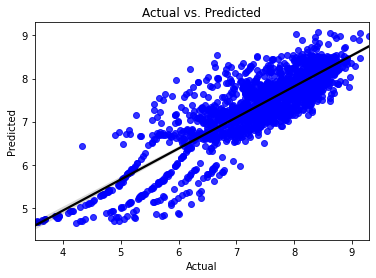

0.8529684330985016

In [27]:
#testing assumptions of linear regression
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results['Residuals'] = abs(results['Actual']) - abs(results['Predicted'])
results

#1)-  Linearity bw y and predictors
sns.regplot(results['Actual'], results['Predicted']  ,
             scatter_kws={"color": "blue"}, line_kws={"color": "black"})
plt.title('Actual vs. Predicted')
plt.show()
#corr r
np.corrcoef(results['Actual'],results['Predicted'])[0,1]

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value= 2.2882788463471318e-29
reject Ho as p-value < 0.05
p-value from the test < 0.05 generally means non-normal


C:\Users\disha\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Residuals', ylabel='Density'>

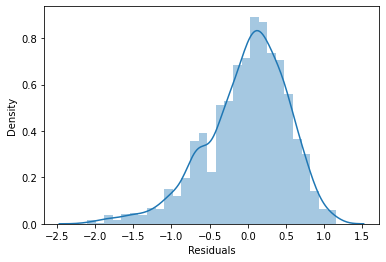

In [28]:
#2)--- Normality of the Error Terms using Anderson-Darling test
from statsmodels.stats.diagnostic import normal_ad
print('Assumption 2: The error terms are normally distributed', '\n')
    
# Calculating residuals for the Anderson-Darling test
print('Using the Anderson-Darling test for normal distribution')

# Performing the test on the residuals
p_value = normal_ad(results['Residuals'])[1]
print('p-value=',p_value)
print('reject Ho as p-value < 0.05')
print('p-value from the test < 0.05 generally means non-normal')
sns.distplot(results['Residuals'])
#residuals are not normally distributed. ASSUMPTION VIOLATED

In [29]:
from scipy.stats import shapiro
stat, p = shapiro(results['Residuals'])
print('Statistic=%.3f, p=%.3f' % (stat, p))  #reject Ho (SHAPIRO WILK TEST)

Statistic=0.970, p=0.000


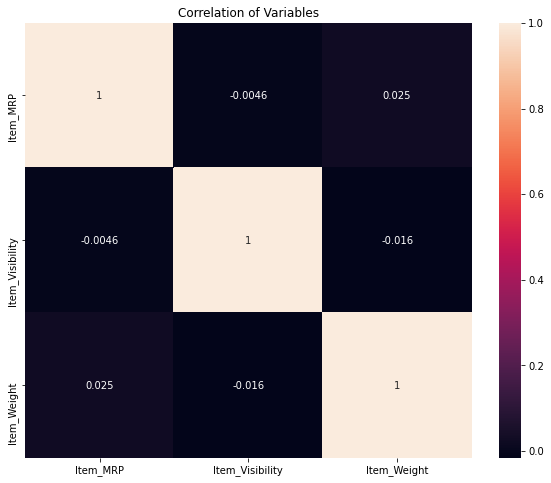

,feature,VIF
0,Item_MRP,4.417630
1,Item_Visibility,2.638746
2,Item_Weight,4.872095


In [30]:
#3)----NO MULTICOLLINEARITY ASSUMPTION
# For categorical variables, multicollinearity can be detected with Spearman rank correlation coefficient (ordinal variables) 
# and chi-square test (nominal variables).
# For a categorical and a continuous variable, multicollinearity can be measured by t-test
# (if the categorical variable has 2 categories) or ANOVA (more than 2 categories).
plt.figure(figsize = (10,8))
sns.heatmap((pd.DataFrame(df22, columns = ['Item_MRP', 'Item_Visibility','Item_Weight'])).corr(), annot=True)
plt.title('Correlation of Variables')
plt.show()
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
c = df22[['Item_MRP', 'Item_Visibility','Item_Weight']]
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = c.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(c.values, i) 
                          for i in range(len(c.columns))] 
vif_data
#ALL VIF < 5 (ASSUMPTION MET)

In [31]:
#4) ---NO AUTOCORRELATION
from statsmodels.stats.stattools import durbin_watson
print('\nPerforming Durbin-Watson Test')
print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
print('0 to 2< is positive autocorrelation')
print('>2 to 4 is negative autocorrelation')
print('-------------------------------------')
durbinWatson = durbin_watson(results['Residuals'])
print('Durbin-Watson:', durbinWatson)
##ASSUMPTION MET


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9863002752662906


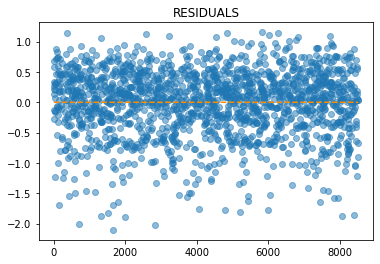

In [32]:
#5)-- HOMOSCEDASTICITY
# Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms
plt.scatter(x=results.index, y=results.Residuals, alpha=0.5)
plt.plot(np.repeat(0, results.index.max()), color='darkorange', linestyle='--')
plt.title('RESIDUALS')
plt.show()
#residuals randomly vary,uniform variance across our residuals. ASSUMPTION MET